# 1) LangGraph 이용한 기본 챗봇 

In [1]:
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI


# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

# 1) State 정의의
class GraphState(TypedDict):
	messages : Annotated[list, add_messages] 

# 2) LLM 정의
llm = ChatOpenAI(model = 'gpt-4o-mini',temperature=0)

# 3) chatbot 노드 정의
def chatbot(state : GraphState):
    return {"messages" : [llm.invoke(state['messages'])]}

# 4) 빈 껍데기 State 생성
graph_builder = StateGraph(GraphState)

# 5) 노드 추가
graph_builder.add_node("chatbot", chatbot)

# 6) 시작 추가
graph_builder.add_edge(START, "chatbot")

# 7) 끝 추가
graph_builder.add_edge("chatbot", END)

# 8) 그래프 컴파일
graph = graph_builder.compile()

# 9) Inference
question = "서울의 유명한 맛집 TOP 5 추천해줘"

# 그래프 이벤트 스트리밍
for event in graph.stream({"messages": [("user", question)]}):
    # 이벤트 값 출력
    for value in event.values():
        print("Assistant:", value["messages"][-1].content)

Assistant: 서울에는 다양한 맛집이 많지만, 다음은 꼭 가봐야 할 유명한 맛집 TOP 5입니다.

1. **광장시장** - 전통 시장으로, 다양한 길거리 음식이 유명합니다. 특히 빈대떡과 마약김밥이 인기입니다.

2. **이태원 부대찌개** - 부대찌개로 유명한 이곳은 한국 전통 음식과 미국식 재료가 조화를 이루는 맛을 제공합니다. 특히 매운 맛을 좋아하는 분들에게 추천합니다.

3. **명동교자** - 칼국수와 만두가 유명한 맛집으로, 깊고 진한 국물 맛이 일품입니다. 항상 많은 사람들이 줄 서서 기다리는 곳입니다.

4. **삼청동 수제비** - 수제비와 전통 한식을 즐길 수 있는 곳으로, 아늑한 분위기에서 식사를 할 수 있습니다. 특히 수제비가 부드럽고 맛있습니다.

5. **한남동 떡볶이** - 매콤한 떡볶이와 다양한 사이드 메뉴가 인기인 곳으로, 젊은 층에게 특히 사랑받고 있습니다. 

이 외에도 서울에는 많은 맛집이 있으니, 다양한 음식을 즐겨보세요!


# 2) LangGraph에 웹 검색 Agent 결합

In [3]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langchain_teddynote.tools.tavily import TavilySearch
from langgraph.graph import StateGraph
import json
from langchain_core.messages import ToolMessage
from langchain_teddynote.graphs import visualize_graph
from langgraph.graph import START, END

# 0) 검색 도구 생성
tool = TavilySearch(max_results=3)

    # 도구 목록에 추가
tools = [tool]

# 도구 실행
# print(tool.invoke("테디노트 랭체인 튜토리얼"))

# 1) State 정의
class State(TypedDict):
    # list 타입에 add_messages 적용(list 에 message 추가)
    messages: Annotated[list, add_messages]

# 2) LLM 초기화
llm = ChatOpenAI(model="gpt-4o-mini")

# LLM 에 도구 바인딩
llm_with_tools = llm.bind_tools(tools)

# 노드 함수 정의
def chatbot(state: State):
    answer = llm_with_tools.invoke(state["messages"])
    # 메시지 목록 반환
    return {"messages": [answer]}  # 자동으로 add_messages 적용

# 상태 그래프 초기화
graph_builder = StateGraph(State)

# 노드 추가
graph_builder.add_node("chatbot", chatbot)

# 다음으로, 도구가 호출될 경우 실제로 실행할 수 있는 함수를 만들어야 합니다. 이를 위해 새로운 노드에 도구를 추가합니다.
# 가장 최근의 메시지를 확인하고 메시지에 tool_calls가 포함되어 있으면 도구를 호출하는 BasicToolNode를 구현합니다.
# 지금은 직접 구현하지만, 나중에는 LangGraph의 pre-built 되어있는 ToolNode 로 대체할 수 있습니다.

class BasicToolNode:
    """Run tools requested in the last AIMessage node"""

    def __init__(self, tools: list) -> None:
        # 도구 리스트
        self.tools_list = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        # 메시지가 존재할 경우 가장 최근 메시지 1개 추출
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")

        ##--------------------------이 부분이 중요!!---------------------------
        # 먼저 도구 이름(웹 검색) 가져오고 args = 질문을 넣어서 tool_result에 웹 검색 결과 넣음
        # 그리고 결과 json으로 처리해서 outputs에 append
          
        # 도구 호출 결과
        outputs = []
        for tool_call in message.tool_calls:
            # 도구 호출 후 결과 저장
            tool_result = self.tools_list[tool_call["name"]].invoke(tool_call["args"])
            outputs.append(
                # 도구 호출 결과를 메시지로 저장
                ToolMessage(
                    content=json.dumps(
                        tool_result, ensure_ascii=False
                    ),  # 도구 호출 결과를 문자열로 변환
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )

        return {"messages": outputs}
    
# 도구 노드 생성
tool_node = BasicToolNode(tools=[tool])

# 그래프에 도구 노드 추가
graph_builder.add_node("tools", tool_node)

## ---------------조건부 엣지 함수-------------------
def route_tools(
    state: State,):
    if messages := state.get("messages", []):
        # 가장 최근 AI 메시지 추출
        ai_message = messages[-1]
    else:
        # 입력 상태에 메시지가 없는 경우 예외 발생
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    
    ## -------------------------------이 부분 중요 !! ------------------------
    # AI 메시지에 도구 호출이 있는 경우 "tools" 반환 -> 웹 검색 하라는 뜻
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        # 도구 호출이 있는 경우 "tools" 반환
        return "tools"
    # 도구 호출이 없는 경우 "END" 반환
    return END

## ------------chatbot 노드에 조건부 엣지 연결 -> path_map을 보면 딕셔너리로 매핑되어 있음----------------------------
# `tools_condition` 함수는 챗봇이 도구 사용을 요청하면 "tools"를 반환하고, 직접 응답이 가능한 경우 "END"를 반환
graph_builder.add_conditional_edges(
    source="chatbot",
    path=route_tools,
    # route_tools 의 반환값이 "tools" 인 경우 "tools" 노드로, 그렇지 않으면 END 노드로 라우팅
    path_map={"tools": "tools", END: END},)

# tools > chatbot
graph_builder.add_edge("tools", "chatbot")

# START > chatbot
graph_builder.add_edge(START, "chatbot")

# 그래프 컴파일
graph = graph_builder.compile()

# 그래프 시각화
visualize_graph(graph)

## -----------------------inference-------------------------------
# 이제 봇에게 훈련 데이터 외의 질문을 할 수 있습니다.
inputs = {"messages": "테디노트 YouTube 채널에 대해서 검색해 줘"}

for event in graph.stream(inputs, stream_mode="values"):
    for key, value in event.items():
        print(f"\n==============\nSTEP: {key}\n==============\n")
        # display_message_tree(value["messages"][-1])
        print(value[-1])

ModuleNotFoundError: No module named 'langchain_teddynote.tools'

- 아래 그림은 tool_calls가 떳을 때 tool message 구조도
- too_calls 안에 arguments와 name을 가지고 구조 설게하면 된다.
- 이유는 어떤 tool을 사용하는지 name을 통해 확인하고 tool에 들어갈 질문은 arguments로 확인한다.

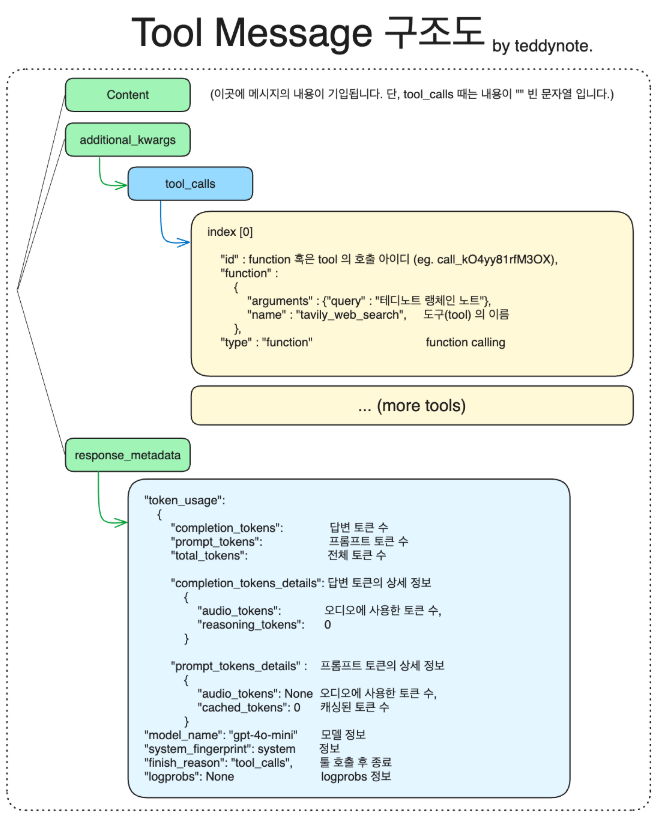

# 3) Agent에 메모리 추가
- 이번 튜토리얼에서는 이를 해결하기 위해 **memory** 를 추가합니다.
- 이번에는 pre-built 되어있는 `ToolNode` 와 `tools_condition` 을 활용합니다.
1. [ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.tool_node.ToolNode): 도구 호출을 위한 노드
2. [tools_condition](https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.tool_node.tools_condition): 도구 호출 여부에 따른 조건 분기

- `LangGraph`는 **persistent checkpointing** 을 통해 이전 상호작용의 **context**를 기억하고 멀티턴 대화를 진행

- 그래프를 컴파일할 때 `checkpointer`를 제공하고 그래프를 호출할 때 `thread_id`를 제공하면, `LangGraph`는 각 단계 후 **상태를 자동으로 저장** 합니다. 동일한 `thread_id`를 사용하여 그래프를 다시 호출하면, 그래프는 저장된 상태를 로드하여 챗봇이 이전에 중단한 지점에서 대화를 이어갈 수 있게 합니다.

- 이번 튜토리얼에서는 `in-memory checkpointer` 를 사용합니다. 

- 하지만, 프로덕션 단계에서는 이를 `SqliteSaver` 또는 `PostgresSaver` 로 변경하고 자체 DB에 연결할 수 있습니다. 

In [4]:
from dotenv import load_dotenv
from langgraph.checkpoint.memory import MemorySaver
from typing import Annotated
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from langchain_teddynote.tools.tavily import TavilySearch
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

# API 키 정보 로드
load_dotenv()

# 메모리 저장소 생성 -> checkpoint

memory = MemorySaver()

ModuleNotFoundError: No module named 'langchain_teddynote.tools'

In [ ]:
########## 1. 상태 정의 ##########
# 상태 정의
class State(TypedDict):
    # 메시지 목록 주석 추가
    messages: Annotated[list, add_messages]


########## 2. 도구 정의 및 바인딩 ##########
# 도구 초기화
tool = TavilySearch(max_results=3)
tools = [tool]

# LLM 초기화
llm = ChatOpenAI(model="gpt-4o-mini")

# 도구와 LLM 결합
llm_with_tools = llm.bind_tools(tools)


########## 3. 노드 추가 ##########
# 챗봇 함수 정의
def chatbot(state: State):
    # 메시지 호출 및 반환
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# 상태 그래프 생성
graph_builder = StateGraph(State)

# 챗봇 노드 추가
graph_builder.add_node("chatbot", chatbot)

# 도구 노드 생성 및 추가 -> Pre-built된 toolnode 활용
tool_node = ToolNode(tools=[tool])

# 도구 노드 추가
graph_builder.add_node("tools", tool_node)

# 조건부 엣지 -> 챗봇에서 tool을 쓸지 말지 결정
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

########## 4. 엣지 추가 ##########

# tools > chatbot
graph_builder.add_edge("tools", "chatbot")

# START > chatbot
graph_builder.add_edge(START, "chatbot")

# chatbot > END
graph_builder.add_edge("chatbot", END)

# 마지막으로, 제공된 `checkpointer`를 사용하여 그래프를 컴파일합니다.
graph = graph_builder.compile(checkpointer=memory)

In [ ]:
# 그래프의 연결성은 `LangGraph-Agent` 와 동일합니다.
# 단지, 이번에 추가된 것은 그래프가 각 노드를 처리하면서 `State`를 체크포인트하는 것뿐입니다.

# 그래프 시각화
visualize_graph(graph)

- **RunnableConfig 설정**
- `RunnableConfig` 을 정의하고 `recursion_limit` 과 `thread_id` 를 설정합니다.
    - `recursion_limit`: 최대 방문할 노드 수. 그 이상은 RecursionError 발생
    - `thread_id`: 스레드 ID 설정

- `thread_id` 는 대화 세션을 구분하는 데 사용됩니다. 즉, 메모리의 저장은 `thread_id` 에 따라 개별적으로 이루어집니다.

In [ ]:
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(recursion_limit=10, # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
                        configurable={"thread_id" : "1"})   # 스레드 ID 설정

# --------------------첫 질문----------------------
question = (
    "내 이름은 `윤왕규` 입니다. YouTube 채널을 운영하고 있어요. 만나서 반가워요")

for event in graph.stream({"messages": [("user", question)]}, config=config):
    for value in event.values():
        value["messages"][-1].pretty_print()

In [ ]:
# ----------------------이어지는 질문-------------------
question = "내 이름이 뭐라고 했지?"

for event in graph.stream({"messages": [("user", question)]}, config=config):
    for value in event.values():
        value["messages"][-1].pretty_print()

In [ ]:
# `thread_id` 를 변경한 뒤, 이전 대화 내용을 기억하고 있는지 물어보겠습니다.
question = "내 이름이 뭐라고 했지?"

config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "2"},  # 스레드 ID 설정
)

for event in graph.stream({"messages": [("user", question)]}, config=config):
    for value in event.values():
        value["messages"][-1].pretty_print()

- **스냅샷 : 저장된 State 확인**

지금까지 두 개의 다른 스레드에서 몇 개의 체크포인트를 만들었습니다. 

`Checkpoint` 에는 현재 상태 값, 해당 구성, 그리고 처리할 `next` 노드가 포함되어 있습니다.

주어진 설정에서 그래프의 `state`를 검사하려면 언제든지 `get_state(config)`를 호출하세요.

In [ ]:
config = RunnableConfig(
    configurable={"thread_id": "1"})  # 스레드 ID 설정

# 그래프 상태 스냅샷 생성
snapshot = graph.get_state(config)
snapshot.values["messages"]

In [ ]:
# `snapshot.config` 를 출력하게 설정된 config 정보를 확인할 수 있습니다.
# 설정된 config 정보
snapshot.config

In [ ]:
# `snapshot.value` 를 출력하게 지금까지 저장된 state 값을 확인할 수 있습니다.
# 저장된 값(values)
snapshot.values

In [ ]:
# `snapshot.next` 를 출력하여 현재 시점에서 앞으로 찾아갈 **다음 노드를 확인** 할 수 있습니다.
# __END__ 에 도달하였기 때문에 다음 노드는 빈 값이 출력됩니다.
# 다음 노드
snapshot.next

In [ ]:
# 복잡한 구조의 metadata 를 시각화하기 위해 `display_message_tree` 함수를 사용합니다.
# 테디노트가 구현한 라이브러리
from langchain_teddynote.messages import display_message_tree

# 메타데이터(tree 형태로 출력)
display_message_tree(snapshot.metadata)

# 기존에 langgraph 라이브러리 안에 있는 정보를 확인하려면 key값으로 들어가야됨
# ex) snapshot.metadata["writes"]["chatbot"]["messages"][0]


# 4) LangGraph 단계별 스트리밍 출력 (노드 단계에서 출력)

- **스트리밍 토큰 출력**(한글자씩 출력되는 형태)과는 다름

- 이번에는 LangGrpah 의 `stream()` 출력 함수에 대한 조금 더 자세한 설명을 진행합니다.

- LangGraph 의 스트리밍 출력 함수는 그래프의 각 단계를 스트리밍하는 기능을 제공합니다.

In [ ]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv
from typing import Annotated, List, Dict
from typing_extensions import TypedDict
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_teddynote.graphs import visualize_graph
from langchain_teddynote.tools import GoogleNews

# API 키 정보 로드
load_dotenv()

# ------------Agent 강의와 노드 구성 같음-----------
class State(TypedDict):
    messages: Annotated[list,add_messages]
    dummy_data: Annotated[str,'dummy']

# 키워드로 뉴스 검색하는 도구 생성
news_tool = GoogleNews()

@tool
def search_keyword(query: str) -> List[Dict[str,str]]:
    """Look up news by keyword"""
    news_tool = GoogleNews()
    return news_tool.search_by_keyword(query,k=5)

tools = [search_keyword]

llm = ChatOpenAI(model="gpt-4o-mini")

llm_with_tools = llm.bind_tools(tools)

def chatbot(state:State):
    return {"messages" : [llm_with_tools.invoke(state['messages'])],
            "dummy_data" : "[chatbot] 호출, dummy data"} # 테스트를 위하여 더미 데이터를 추가합니다.

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()
visualize_graph(graph)

### StateGraph의 `stream` 메서드

`stream` 메서드는 단일 입력에 대한 그래프 단계를 스트리밍하는 기능을 제공합니다.

**매개변수**
- `input` (Union[dict[str, Any], Any]): 그래프에 대한 입력
- `config` (Optional[RunnableConfig]): 실행 구성
- `stream_mode` (Optional[Union[StreamMode, list[StreamMode]]]): 출력 스트리밍 모드
- `output_keys` (Optional[Union[str, Sequence[str]]]): 스트리밍할 키
- `interrupt_before` (Optional[Union[All, Sequence[str]]]): 실행 전에 중단할 노드
- `interrupt_after` (Optional[Union[All, Sequence[str]]]): 실행 후에 중단할 노드
- `debug` (Optional[bool]): 디버그 정보 출력 여부
- `subgraphs` (bool): 하위 그래프 스트리밍 여부

**반환값**
- Iterator[Union[dict[str, Any], Any]]: 그래프의 각 단계 출력. 출력 형태는 `stream_mode`에 따라 다름

**주요 기능**
1. 입력된 설정에 따라 그래프 실행을 스트리밍 방식으로 처리
2. 다양한 스트리밍 모드 지원 (`values`, `updates`, `debug`)
3. 콜백 관리 및 오류 처리
4. 재귀 제한 및 중단 조건 처리

**스트리밍 모드**
- `values`: 각 단계의 현재 상태 값 출력
- `updates`: 각 단계의 상태 업데이트만 출력
- `debug`: 각 단계의 디버그 이벤트 출력

In [ ]:
from langchain_core.runnables import RunnableConfig

# 질문
question = "2024년 노벨 문학상 관련 뉴스를 알려주세요."

# 초기 입력 상태를 정의
input = State(dummy_data="테스트 문자열", messages=[("user", question)])

# config 설정
config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
    tags=["my-tag"],  # Tag
)

for event in graph.stream(input=input, config=config):
    for key, value in event.items():
        print(f"\n[ {key} ]\n") # key에는 '노드의 이름'
        # value 에 messages 가 존재하는 경우
        if "messages" in value:
            messages = value["messages"]
            # 가장 최근 메시지 1개만 출력합니다.
            value["messages"][-1].pretty_print()

# 결론적으로) stream이라는 메소드는 각 단계별로 실시간으로 결과를 출력해줌줌

### `output_keys` 옵션

`output_keys` 옵션은 스트리밍할 키를 지정하는 데 사용됩니다.

list 형식으로 지정할 수 있으며, **channels 에 정의된 키 중 하나** 여야 합니다.

**팁(tip)**

- 매 단계마다 출력되는 State key 가 많은 경우, 일부만 스트리밍하고 싶은 경우에 유용합니다.

In [ ]:
# channels 에 정의된 키 목록을 출력합니다.
print(list(graph.channels.keys()))

# 질문
question = "2024년 노벨 문학상 관련 뉴스를 알려주세요."

# 초기 입력 State 를 정의
input = State(dummy_data="테스트 문자열", messages=[("user", question)])

# config 설정
config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
    tags=["my-rag"],  # Tag
)

for event in graph.stream(
    input=input,
    config=config,
    output_keys=["dummy_data","messages"],  # messages 를 추가해 보세요!
):  # output_keys는 한마디로 워하는 결과값만 보고싶다 -> 필터링
    for key, value in event.items():
        # key 는 노드 이름
        print(f"\n[ {key} ]\n")

        # dummy_data 가 존재하는 경우
        if value:
            # value 는 노드의 출력값
            print(value.keys())
            # dummy_data key 가 존재하는 경우
            if "dummy_data" in value:
                print(value["dummy_data"])
            # messages 추가할 경우
            if "messages" in value:
                print(value["messages"])

In [ ]:
# 질문
question = "2024년 노벨 문학상 관련 뉴스를 알려주세요."

# 초기 입력 State 를 정의
input = State(dummy_data="테스트 문자열", messages=[("user", question)])

# config 설정
config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
    tags=["my-rag"],  # Tag
)

for event in graph.stream(
    input=input,
    config=config,
    output_keys=["messages"],  # messages 만 출력
):
    for key, value in event.items():
        # messages 가 존재하는 경우
        if value and "messages" in value:
            # key 는 노드 이름
            print(f"\n[ {key} ]\n")
            # messages 의 마지막 요소의 content 를 출력합니다.
            print(value["messages"][-1].content)

### `stream_mode` 옵션

`stream_mode` 옵션은 스트리밍 출력 모드를 지정하는 데 사용됩니다.

- `values`: 각 단계의 현재 상태 값 출력 
    - ex) `stream_mode = "values"`

        - `values` 모드는 각 단계의 현재 상태 값을 출력합니다.

    - **참고**
    - event.items()`

        - `key`: State 의 key 값
        - `value`: State 의 key 에 대한하는 value
- `updates`: 각 단계의 상태 업데이트만 출력 (기본값)
    - ex) `stream_mode = "updates"`

        - `updates` 모드는 각 단계에 대한 업데이트된 State 만 내보냅니다. 

        - 출력은 노드 이름을 key 로, 업데이트된 값을 values 으로 하는 `dictionary` 입니다.

    - **참고**
    - `event.items()`

        - `key`: 노드(Node) 의 이름
        - `value`: 해당 노드(Node) 단계에서의 출력 값(dictionary). 즉, 여러 개의 key-value 쌍을 가진 dictionary 입니다.

In [ ]:
# 질문
question = "2024년 노벨 문학상 관련 뉴스를 알려주세요."

# 초기 입력 State 를 정의
input = State(dummy_data="테스트 문자열", messages=[("user", question)])

# config 설정
config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
    tags=["my-rag"],  # Tag
)

# ---------------values 모드로 스트리밍 출력
for event in graph.stream(
    input=input,
    stream_mode="values",  # <---------------------------기본값
):
    for key, value in event.items():
        # key 는 state 의 key 값
        print(f"\n[ {key} ]\n")
        if key == "messages":
            print(f"메시지 개수: {len(value)}")
            # print(value)
    print("===" * 10, " 단계 ", "===" * 10)

In [ ]:
# 질문
question = "2024년 노벨 문학상 관련 뉴스를 알려주세요."

# 초기 입력 State 를 정의
input = State(dummy_data="테스트 문자열", messages=[("user", question)])

# config 설정
config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
    tags=["my-rag"],  # Tag
)

# ------------------------updates 모드로 스트리밍 출력
for event in graph.stream(
    input=input,
    stream_mode="updates",  # <----------------------기본값
):
    for key, value in event.items():
        # key 는 노드 이름
        print(f"\n[ {key} ]\n")     # [chatbot] 이렇게 노드 이름 출력함

        # value 는 노드의 출력값
        print(value.keys())         # dict_keys(['messages','dummy_data']) 이렇게 출력

        # value 에는 state 가 dict 형태로 저장(values 의 key 값)
        if "messages" in value:
            print(f"메시지 개수: {len(value['messages'])}")
            # print(value["messages"])
    print("===" * 10, " 단계 ", "===" * 10)

#### `interrupt_before` 와 `interrupt_after` 옵션

`interrupt_before` 와 `interrupt_after` 옵션은 스트리밍 중단 시점을 지정하는 데 사용됩니다.

- `interrupt_before`: 지정된 노드 이전에 스트리밍 중단
- `interrupt_after`: 지정된 노드 이후에 스트리밍 중단

In [ ]:
# 질문
question = "2024년 노벨 문학상 관련 뉴스를 알려주세요."

# 초기 입력 State 를 정의
input = State(dummy_data="테스트 문자열", messages=[("user", question)])

# config 설정
config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
    tags=["my-rag"],  # Tag
)

for event in graph.stream(
    input=input,
    config=config,
    stream_mode="updates",  # 기본값
    interrupt_before=["tools"],  # <-----------------tools 노드 이전에 스트리밍 중단
):
    for key, value in event.items():
        # key 는 노드 이름
        print(f"\n[{key}]\n")

        # value 는 노드의 출력값
        if isinstance(value, dict):
            print(value.keys())
            if "messages" in value:
                print(value["messages"])

        # value 에는 state 가 dict 형태로 저장(values 의 key 값)
        if "messages" in value:
            print(f"메시지 개수: {len(value['messages'])}")
    print("===" * 10, " 단계 ", "===" * 10)

In [ ]:
# 질문
question = "2024년 노벨 문학상 관련 뉴스를 알려주세요."

# 초기 입력 State 를 정의
input = State(dummy_data="테스트 문자열", messages=[("user", question)])

# config 설정
config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
    tags=["my-rag"],  # Tag
)

for event in graph.stream(
    input=input,
    config=config,
    stream_mode="updates",
    interrupt_after=["tools"],  # <-------------------------tools 실행 후 interrupt
):
    for value in event.values():
        # key 는 노드 이름
        print(f"\n[{key}]\n")

        if isinstance(value, dict):
            # value 는 노드의 출력값
            print(value.keys())
            if "messages" in value:
                print(value["messages"])

        # value 에는 state 가 dict 형태로 저장(values 의 key 값)
        if "messages" in value:
            print(f"메시지 개수: {len(value['messages'])}")